# Initial Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from collections import defaultdict
import scipy.stats as stats
import copy

import warnings
warnings.filterwarnings("ignore", category = UserWarning)

# Preprocessing

In [2]:
# Preprocess dataset (Outputs: ids, trial_nums, predictors_df, outcomes_df, outcomes_df_shuffled)
# Import dataset
df = pd.read_csv("./../../Datasets/kieranFeatures_1-31_21-Jan-2025_avgof3_rawSA.csv").replace([np.inf, -np.inf], np.nan)

# Create Low vs High Columns
df["Lv_1_Lo"] = (df["SA1"] < 5).astype(np.bool_)
df["Lv_2_Lo"] = (df["SA2"] < 5).astype(np.bool_)
df["Lv_3_Lo"] = (df["SA3"] < 5).astype(np.bool_)
df["Tot_Lo"] = (df["SAtotal"] < 15).astype(np.bool_)

# Impute missing values with mean of column
for col in df.columns:
    df[col] = df[col].fillna(value = df[col].mean())

# Split up dataset
ids = df["ID"].astype(np.uint8)
predictors_df = df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal", "Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]).astype(np.float64)
outcomes_df = df[["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]]
outcomes_df_shuffled = outcomes_df.copy()

# Shuffle labels for shuffled data
outcomes_df_shuffled["Lv_1_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_1_Lo"])
outcomes_df_shuffled["Lv_2_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_2_Lo"])
outcomes_df_shuffled["Lv_3_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_3_Lo"])
outcomes_df_shuffled["Tot_Lo"] = np.random.permutation(outcomes_df_shuffled["Tot_Lo"])

# Divide up dataframe
ids = df["ID"]
ECG_df = df.loc[:, [col for col in df if col.startswith("ECG")]]
EDA_df = df.loc[:, [col for col in df if col.startswith("EDA")]]
EEG_df = df.loc[:, [col for col in df if col.startswith("EEG")]]
EYE_df = df.loc[:, [col for col in df if col.startswith("EYE")]]
fNIRS_df = df.loc[:, [col for col in df if col.startswith("fNIRS")]]
RSP_df = df.loc[:, [col for col in df if col.startswith("RSP")]]
sensor_dfs = [(ECG_df, "ECG"), (EDA_df, "EDA"), (EEG_df, "EEG"), (EYE_df, "EYE"), (fNIRS_df, "fNIRS"), (RSP_df, "RSP")]

# Free up memory
del col, df, predictors_df

In [3]:
# Initialize f1_scores, accuracy_scores, models
dataset_types = ["Actual", "Shuffled"]
levels = ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]
sensor_names = ["ECG", "EDA", "EEG", "EYE", "fNIRS", "RSP"]

f1_scores = {}
accuracy_scores = {}
models = {}

for data in [f1_scores, accuracy_scores, models]:
    for dataset in dataset_types:
        data[dataset] = {}

        for level in levels:
            data[dataset][level] = {}

            for sensor in sensor_names:
                data[dataset][level][sensor] = []

del data, dataset, sensor, level

In [4]:
logistic_models = {
    "Lv_1_Lo": {
        "ECG": LogisticRegression(C=0.01, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
        "EDA": LogisticRegression(C=100, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
        "EEG": LogisticRegression(C=10, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
        "EYE": LogisticRegression(C=0.001, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
        "fNIRS": LogisticRegression(C=0.01, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
        "RSP": LogisticRegression(C=0.01, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
    },
    "Lv_2_Lo": {
        "ECG": LogisticRegression(C=10, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
        "EDA": LogisticRegression(C=0.1, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
        "EEG": LogisticRegression(C=0.1, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
        "EYE": LogisticRegression(C=0.01, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
        "fNIRS": LogisticRegression(C=0.001, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
        "RSP": LogisticRegression(C=10, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
    },
    "Lv_3_Lo": {
        "ECG": LogisticRegression(C=10, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
        "EDA": LogisticRegression(C=0.1, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
        "EEG": LogisticRegression(C=0.01, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
        "EYE": LogisticRegression(C=0.1, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
        "fNIRS": LogisticRegression(C=0.001, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
        "RSP": LogisticRegression(C=1000, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
    },
    "Tot_Lo": {
        "ECG": LogisticRegression(C=100, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
        "EDA": LogisticRegression(C=10, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
        "EEG": LogisticRegression(C=0.1, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
        "EYE": LogisticRegression(C=0.01, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
        "fNIRS": LogisticRegression(C=0.001, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
        "RSP": LogisticRegression(C=1, solver="saga", max_iter=20000, class_weight="balanced", n_jobs=-1, random_state=42),
    }
}

# Training

In [5]:
def train_sensor_models(pred_df, out_df, sensor, level):
    f1_sensor_scores = []
    accuracy_sensor_scores = []
    sensor_models = []

    # Obtain 10 test folds stratifying by participant ID
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    for i, (train_idx, test_idx) in enumerate(skf.split(pred_df, ids)):
        # Train-Test Split for the Fold
        pred_train = pred_df.iloc[train_idx, :].values
        pred_test = pred_df.iloc[test_idx, :].values
        out_train = out_df.loc[train_idx, level].values
        out_test = out_df.loc[test_idx, level].values

        # Standardize Data
        scaler = StandardScaler()
        pred_train_normalized = scaler.fit_transform(pred_train)
        pred_test_normalized = scaler.transform(pred_test)

        # Free Up Memory
        del pred_train
        del pred_test

        # Fit Models
        model = copy.deepcopy(logistic_models[level][sensor])
        model.fit(pred_train_normalized, out_train)

        # Take Note of Metrics and Model
        f1_sensor_scores.append(f1_score(out_test, model.predict(pred_test_normalized)))
        accuracy_sensor_scores.append(accuracy_score(out_test, model.predict(pred_test_normalized)))
        sensor_models.append(model)

    return f1_sensor_scores, accuracy_sensor_scores, sensor_models

In [6]:
for dataset_type in dataset_types:
    for level in levels:
        for sensor_df, sensor in sensor_dfs:
            if dataset_type == "Actual":
                f1_scores[dataset_type][level][sensor], accuracy_scores[dataset_type][level][sensor], models[dataset_type][level][sensor] = train_sensor_models(sensor_df, outcomes_df, sensor, level)
            else:
                f1_scores[dataset_type][level][sensor], accuracy_scores[dataset_type][level][sensor], models[dataset_type][level][sensor] = train_sensor_models(sensor_df, outcomes_df_shuffled, sensor, level)
            
            print("Completed Training for", dataset_type, level, sensor)

Completed Training for Actual Lv_1_Lo ECG
Completed Training for Actual Lv_1_Lo EDA
Completed Training for Actual Lv_1_Lo EEG
Completed Training for Actual Lv_1_Lo EYE
Completed Training for Actual Lv_1_Lo fNIRS
Completed Training for Actual Lv_1_Lo RSP
Completed Training for Actual Lv_2_Lo ECG
Completed Training for Actual Lv_2_Lo EDA
Completed Training for Actual Lv_2_Lo EEG
Completed Training for Actual Lv_2_Lo EYE
Completed Training for Actual Lv_2_Lo fNIRS
Completed Training for Actual Lv_2_Lo RSP
Completed Training for Actual Lv_3_Lo ECG
Completed Training for Actual Lv_3_Lo EDA
Completed Training for Actual Lv_3_Lo EEG
Completed Training for Actual Lv_3_Lo EYE
Completed Training for Actual Lv_3_Lo fNIRS
Completed Training for Actual Lv_3_Lo RSP
Completed Training for Actual Tot_Lo ECG
Completed Training for Actual Tot_Lo EDA
Completed Training for Actual Tot_Lo EEG
Completed Training for Actual Tot_Lo EYE
Completed Training for Actual Tot_Lo fNIRS
Completed Training for Actual T

In [7]:
# Save data
with open("./../../Pickle Files/3_Moving_Average_Model_by_Sensor_With_Intercepts.pkl", "wb") as f:
    pickle.dump((f1_scores, accuracy_scores, models), f)

In [8]:
# Load data
with open("./../../Pickle Files/3_Moving_Average_Model_by_Sensor_With_Intercepts.pkl", "rb") as f:
    f1_scores, accuracy_scores, models = pickle.load(f)

# Evaluating Individual Sensor Models

In [13]:
def sensor_actual_vs_shuffled(model_scores, metric, level):
    for sensor in ["ECG", "EDA", "EEG", "EYE", "fNIRS", "RSP"]:
        # Intiailize Baselines
        baselines = []
        always_true_lines = []
        always_false_lines = []

        # Get baselines for each fold
        skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
        for i, (_, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            # Train-Test Split for the Fold
            out_test = outcomes_df.iloc[test_idx]

            if metric == "F1":
                baselines.append((np.mean(out_test[level])) / (np.mean(out_test[level]) + 0.5))
                always_true_lines.append(f1_score(out_test[level], np.array([1 for _ in range(len(out_test[level]))])))
            elif metric == "Accuracy":
                baselines.append(0.5)
                always_false_lines.append(accuracy_score(outcomes_df[level], np.array([0 for _ in range(len(outcomes_df[level]))])))

        fig = plt.figure(figsize = (7.5, 7.5))

        actual_scores = model_scores["Actual"][level][sensor]
        shuffled_scores = model_scores["Shuffled"][level][sensor]

        # Plot Actual vs Shuffled
        for i, (actual_score, shuffled_score) in enumerate(zip(actual_scores, shuffled_scores)):
            plt.plot([0, 1], [actual_score, shuffled_score], marker = "o", label = f"Test Fold {i + 1}")

        # Model 1 Data Boxplot
        plt.boxplot(actual_scores, vert = True, positions = [-0.1])

        # Shuffled Data Boxplot
        plt.boxplot(shuffled_scores, vert = True, positions = [1.1])

        # Baselines
        if metric == "F1":
            plt.axhline(y = np.mean(always_true_lines), color = "r", label = "Always True", linestyle = "--")
        elif metric == "Accuracy":
            plt.axhline(y = np.mean(always_false_lines), color = "b", label = "Always True", linestyle = "--")
        plt.axhline(y = np.mean(baselines), color = "black", label = "Baseline", linestyle = "--")

        # Visual Adjustments
        plt.xticks([0, 1], ["Actual", "Shuffled"])
        plt.xlim([-0.2, 1.2])
        plt.ylim([0, 1])
        
        # Labeling
        plt.xlabel("Model Type")
        plt.ylabel(f"{metric} Score")
        plt.title(f"{sensor} {metric} Test Fold Scores for {level} Models")
        plt.legend(loc = "upper right", bbox_to_anchor = [1.3, 1])
        
        plt.show()

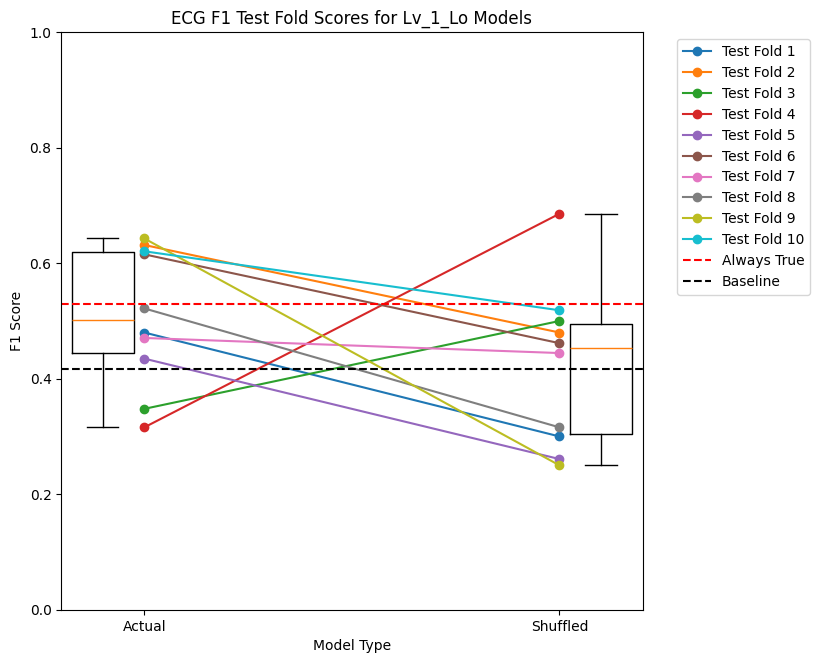

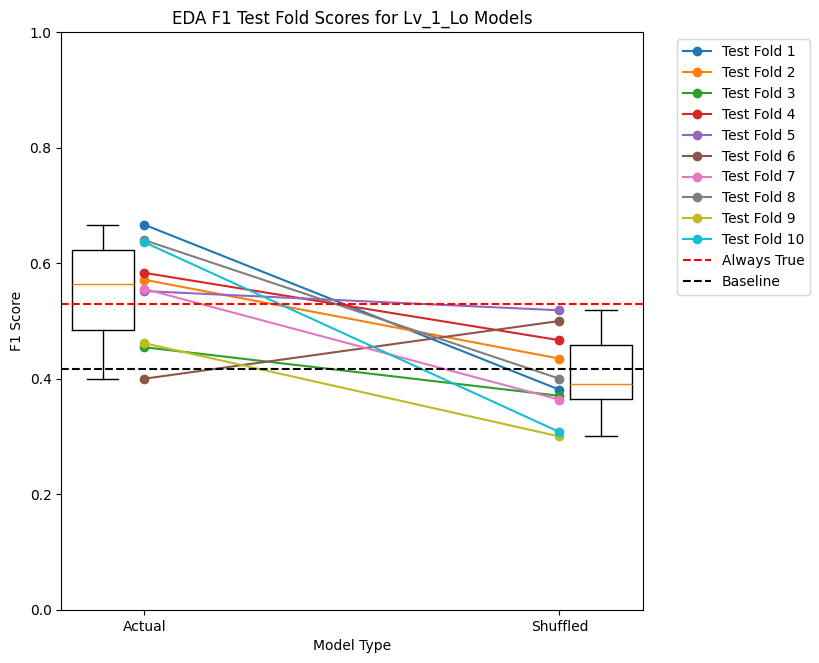

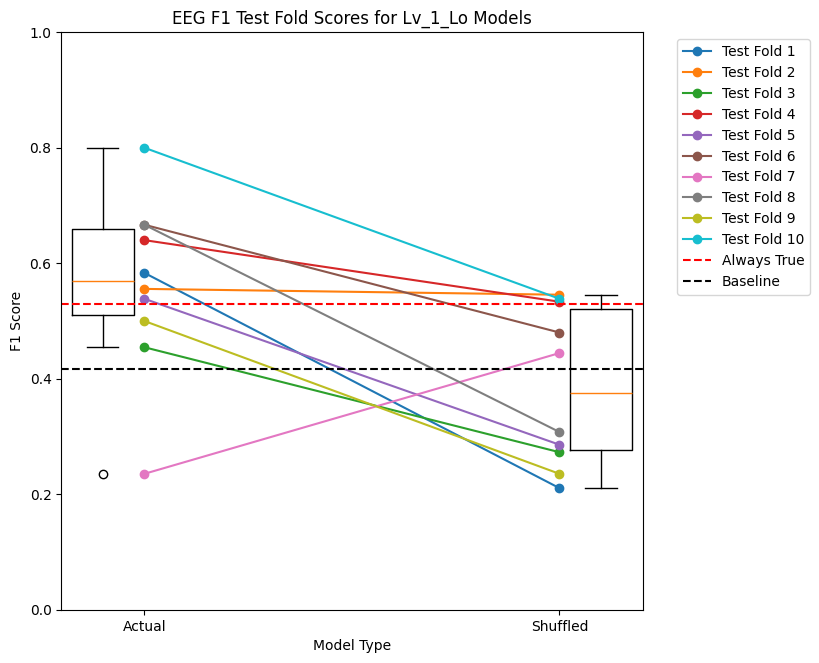

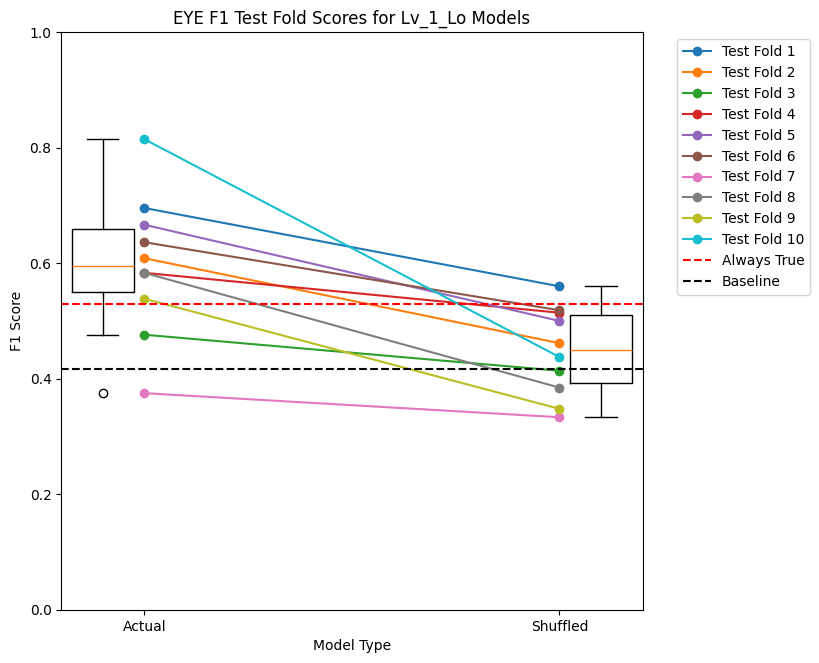

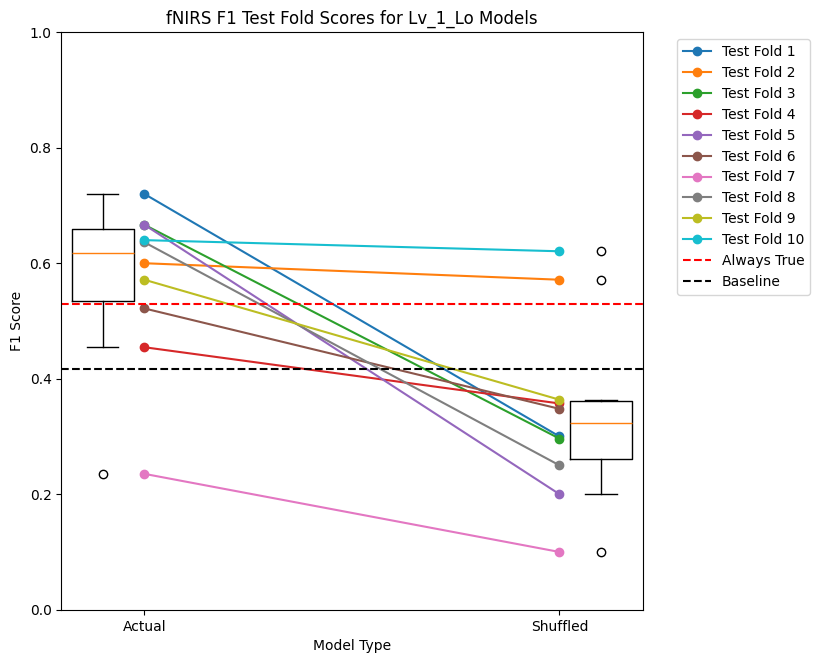

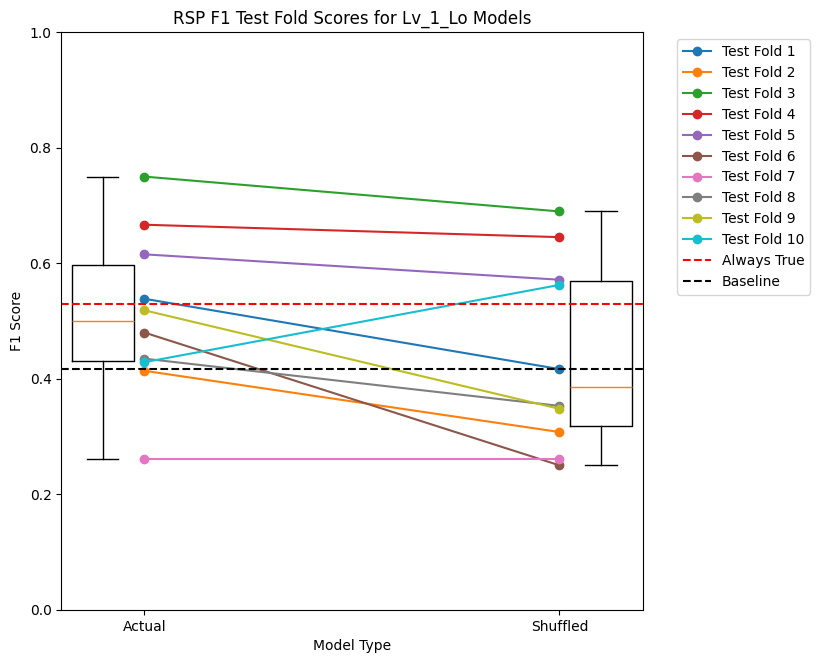

In [14]:
sensor_actual_vs_shuffled(f1_scores, "F1", "Lv_1_Lo")

# Majority Voting

In [3]:
# Load data
with open("./../../Pickle Files/3_Moving_Average_Model_by_Sensor_With_Intercepts.pkl", "rb") as f:
    f1_scores, accuracy_scores, models = pickle.load(f)

del f1_scores, accuracy_scores, f

## Get Predictions

In [4]:
# Initialize data storage
dataset_types = ["Actual", "Shuffled"]
levels = ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]

majority_voting_predictions = {}

for dataset in dataset_types:
    majority_voting_predictions[dataset] = {}

    for level in levels:
        majority_voting_predictions[dataset][level] = []

del dataset, level

In [5]:
# Tally up and store majority voting predictions
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
for dataset_type in dataset_types:
    for level in levels:
        for i, (train_idx, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            votes = np.array([0 for _ in range(len(test_idx))])

            for sensor, df in [("ECG", ECG_df), ("EDA", EDA_df), ("EEG", EEG_df), ("EYE", EYE_df), ("fNIRS", fNIRS_df)]:
                # Train-Test Split for the Fold
                pred_train = df.iloc[train_idx, :]
                pred_test = df.iloc[test_idx, :]

                # Standardize Data
                scaler = StandardScaler()
                pred_train_normalized = scaler.fit_transform(pred_train)
                pred_test_normalized = scaler.transform(pred_test)

                # Free Up Memory
                del pred_train, pred_train_normalized, pred_test

                votes = np.add(votes, models[dataset_type][level][sensor][i].predict(pred_test_normalized).astype(int))

                majority_voting_predictions[dataset_type][level].append(votes >= 3)

del models
del skf, dataset_type, level, i, train_idx, test_idx, votes, sensor, df, pred_test_normalized, scaler

## Get F1 and Accuracy Scores

In [6]:
# Initialize f1_scores and accuracy_scores
f1_scores = {}
accuracy_scores = {}

for data in [f1_scores, accuracy_scores]:
    for dataset in dataset_types:
        data[dataset] = {}

        for level in levels:
            data[dataset][level] = []

del data, dataset, level

In [7]:
# Calculate F1 and Accuracy Scores
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
for dataset_type in dataset_types:
    for level in levels:
        for i, (CV_idx, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            out_test = outcomes_df.loc[test_idx, level].values

            f1_scores[dataset_type][level].append(f1_score(out_test, majority_voting_predictions[dataset_type][level][i]))
            accuracy_scores[dataset_type][level].append(accuracy_score(out_test, majority_voting_predictions[dataset_type][level][i]))

del skf, dataset_type, level, i, CV_idx, test_idx, out_test

## Graphing

In [8]:
def graph_actual_vs_shuffled(model_scores, metric, level):
    # Intiailize Baselines
    baselines = []
    always_true_lines = []
    always_false_lines = []

    # Get baselines for each fold
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    for i, (_, test_idx) in enumerate(skf.split(outcomes_df, ids)):
        # Train-Test Split for the Fold
        out_test = outcomes_df.iloc[test_idx]

        if metric == "F1":
            baselines.append((np.mean(out_test[level])) / (np.mean(out_test[level]) + 0.5))
            always_true_lines.append(f1_score(out_test[level], np.array([1 for _ in range(len(out_test[level]))])))
        elif metric == "Accuracy":
            baselines.append(0.5)
            always_false_lines.append(accuracy_score(outcomes_df[level], np.array([0 for _ in range(len(outcomes_df[level]))])))

    fig = plt.figure(figsize = (7.5, 7.5))

    actual_scores = model_scores["Actual"][level]
    shuffled_scores = model_scores["Shuffled"][level]

    # Plot Actual vs Shuffled
    for i, (actual_score, shuffled_score) in enumerate(zip(actual_scores, shuffled_scores)):
        plt.plot([0, 1], [actual_score, shuffled_score], marker = "o", label = f"Test Fold {i + 1}")

    # Model 1 Data Boxplot
    plt.boxplot(actual_scores, vert = True, positions = [-0.1])

    # Shuffled Data Boxplot
    plt.boxplot(shuffled_scores, vert = True, positions = [1.1])

    # Baselines
    if metric == "F1":
        plt.axhline(y = np.mean(always_true_lines), color = "r", label = "Always True", linestyle = "--")
    elif metric == "Accuracy":
        plt.axhline(y = np.mean(always_false_lines), color = "b", label = "Always True", linestyle = "--")
    plt.axhline(y = np.mean(baselines), color = "black", label = "Baseline", linestyle = "--")

    # Visual Adjustments
    plt.xticks([0, 1], ["Actual", "Shuffled"])
    plt.xlim([-0.2, 1.2])
    plt.ylim([0, 1])
    
    # Labeling
    plt.xlabel("Model Type")
    plt.ylabel(f"{metric} Score")
    plt.title(f"{metric} Test Fold Scores for {level} Models")
    plt.legend(loc = "upper right", bbox_to_anchor = [1.3, 1])
    
    plt.show()

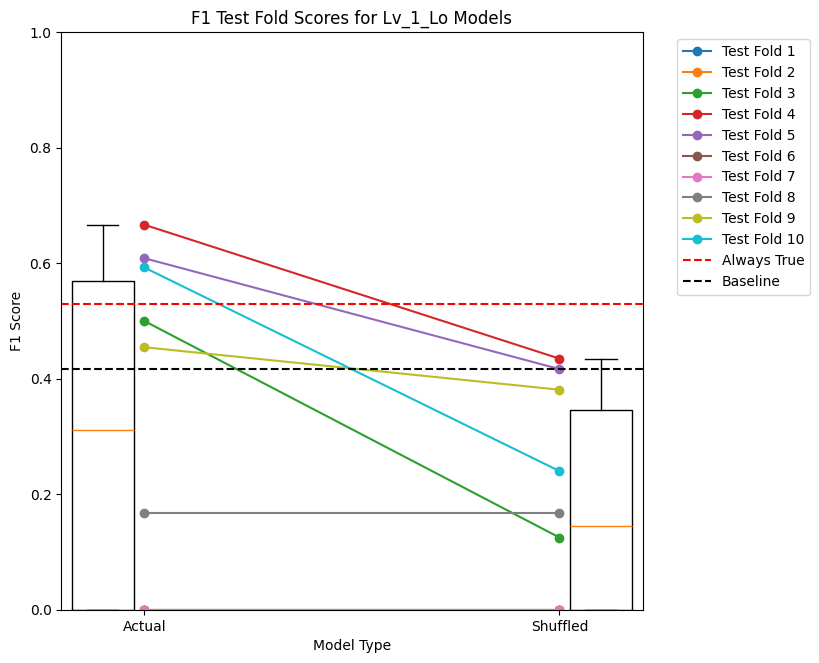

In [9]:
graph_actual_vs_shuffled(f1_scores, "F1", "Lv_1_Lo")

# Average Probability

In [3]:
# Load data
with open("./../../Pickle Files/3_Moving_Average_Model_by_Sensor_With_Intercepts.pkl", "rb") as f:
    f1_scores, accuracy_scores, models = pickle.load(f)

del f1_scores, accuracy_scores, f

## Get Predictions

In [4]:
# Initialize data storage
dataset_types = ["Actual", "Shuffled"]
levels = ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]

average_probability_predictions = {}

for dataset in dataset_types:
    average_probability_predictions[dataset] = {}

    for level in levels:
        average_probability_predictions[dataset][level] = []

del dataset, level

In [5]:
# Tally up and store majority voting predictions
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
for dataset_type in dataset_types:
    for level in levels:
        for i, (train_idx, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            votes = np.array([0.0 for _ in range(len(test_idx))])

            for sensor, df in [("ECG", ECG_df), ("EDA", EDA_df), ("EEG", EEG_df), ("EYE", EYE_df), ("fNIRS", fNIRS_df)]:
                # Train-Test Split for the Fold
                pred_train = df.iloc[train_idx, :]
                pred_test = df.iloc[test_idx, :]

                # Standardize Data
                scaler = StandardScaler()
                pred_train_normalized = scaler.fit_transform(pred_train)
                pred_test_normalized = scaler.transform(pred_test)

                # Free Up Memory
                del pred_train, pred_train_normalized, pred_test

                votes = np.add(votes, models[dataset_type][level][sensor][i].predict_proba(pred_test_normalized)[:, 1])

            average_probability_predictions[dataset_type][level].append(votes >= 2.5)

del models
del skf, dataset_type, level, i, train_idx, test_idx, votes, sensor, df, pred_test_normalized, scaler

## Get F1 and Accuracy Scores

In [6]:
# Initialize f1_scores and accuracy_scores
f1_scores = {}
accuracy_scores = {}

for data in [f1_scores, accuracy_scores]:
    for dataset in dataset_types:
        data[dataset] = {}

        for level in levels:
            data[dataset][level] = []

del data, dataset, level

In [7]:
# Calculate F1 and Accuracy Scores
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
for dataset_type in dataset_types:
    for lvl in levels:
        for i, (_, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            out_test = outcomes_df.loc[test_idx, lvl].values

            f1_scores[dataset_type][lvl].append(f1_score(out_test, average_probability_predictions[dataset_type][lvl][i]))
            accuracy_scores[dataset_type][lvl].append(accuracy_score(out_test, average_probability_predictions[dataset_type][lvl][i]))

del skf, dataset_type, lvl, i, test_idx, out_test

## Graphing

In [8]:
def graph_actual_vs_shuffled(model_scores, metric, level):
    # Intiailize Baselines
    baselines = []
    always_true_lines = []
    always_false_lines = []

    # Get baselines for each fold
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    for i, (_, test_idx) in enumerate(skf.split(outcomes_df, ids)):
        # Train-Test Split for the Fold
        out_test = outcomes_df.iloc[test_idx]

        if metric == "F1":
            baselines.append((np.mean(out_test[level])) / (np.mean(out_test[level]) + 0.5))
            always_true_lines.append(f1_score(out_test[level], np.array([1 for _ in range(len(out_test[level]))])))
        elif metric == "Accuracy":
            baselines.append(0.5)
            always_false_lines.append(accuracy_score(outcomes_df[level], np.array([0 for _ in range(len(outcomes_df[level]))])))

    fig = plt.figure(figsize = (7.5, 7.5))

    actual_scores = model_scores["Actual"][level]
    shuffled_scores = model_scores["Shuffled"][level]

    # Plot Actual vs Shuffled
    for i, (actual_score, shuffled_score) in enumerate(zip(actual_scores, shuffled_scores)):
        plt.plot([0, 1], [actual_score, shuffled_score], marker = "o", label = f"Test Fold {i + 1}")

    # Model 1 Data Boxplot
    plt.boxplot(actual_scores, vert = True, positions = [-0.1])

    # Shuffled Data Boxplot
    plt.boxplot(shuffled_scores, vert = True, positions = [1.1])

    # Baselines
    if metric == "F1":
        plt.axhline(y = np.mean(always_true_lines), color = "r", label = "Always True", linestyle = "--")
    elif metric == "Accuracy":
        plt.axhline(y = np.mean(always_false_lines), color = "b", label = "Always True", linestyle = "--")
    plt.axhline(y = np.mean(baselines), color = "black", label = "Baseline", linestyle = "--")

    # Visual Adjustments
    plt.xticks([0, 1], ["Actual", "Shuffled"])
    plt.xlim([-0.2, 1.2])
    plt.ylim([0, 1])
    
    # Labeling
    plt.xlabel("Model Type")
    plt.ylabel(f"{metric} Score")
    plt.title(f"{metric} Test Fold Scores for {level} Models")
    plt.legend(loc = "upper right", bbox_to_anchor = [1.3, 1])
    
    plt.show()

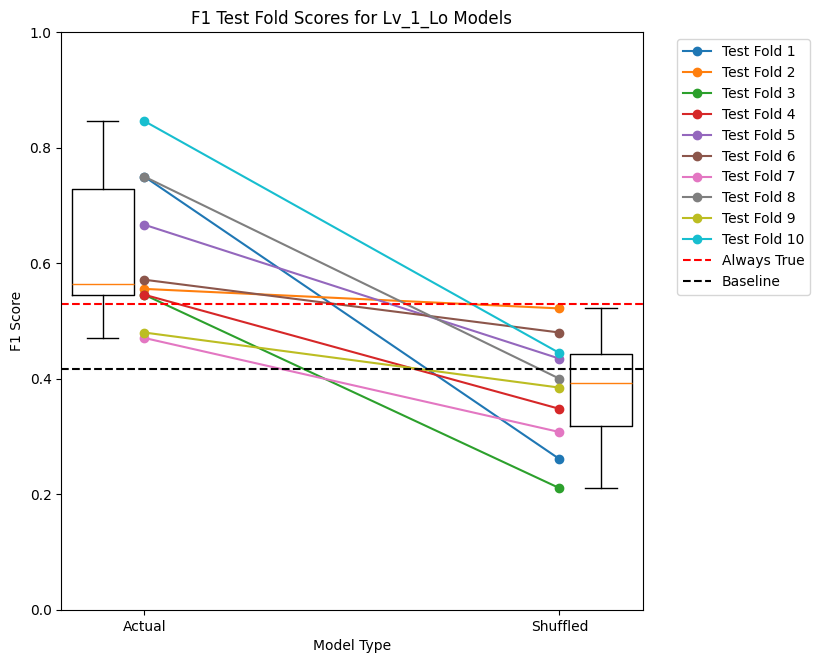

In [10]:
graph_actual_vs_shuffled(f1_scores, "F1", "Lv_1_Lo")

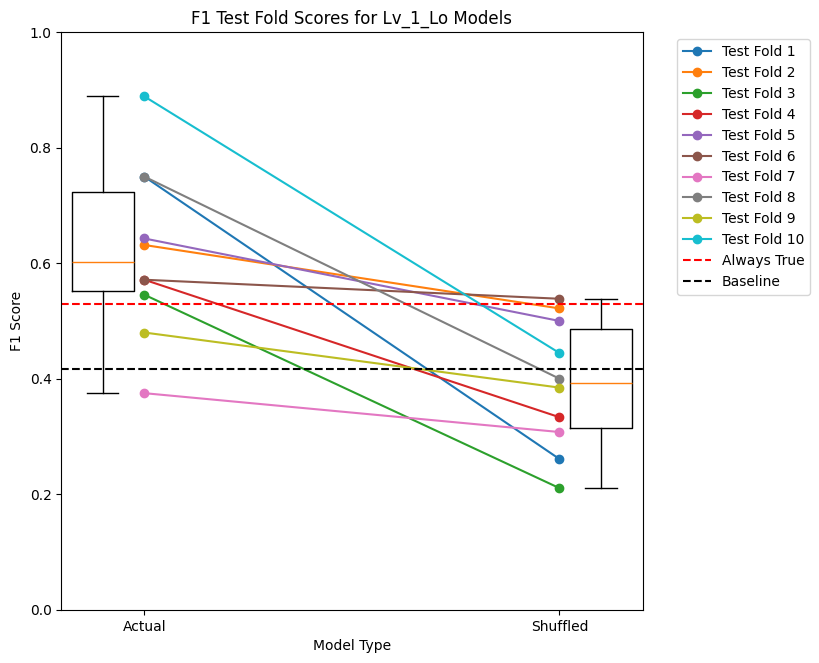

In [9]:
graph_actual_vs_shuffled(f1_scores, "F1", "Lv_1_Lo")